# Code Division Multiplexing: HTC Tutorial using Jupyter notebooks

## Student project in High Throughput Computing

<br>Netid
<br>Started:
<p>I certify that this notebook was filled in by me, and represents my own original work.
<br>Signed:


## Introduction
This project explores the power of code-division multiplexing to encode a message within the correlations between the samples of an otherwise purely random and uncorrelated time series. The final goal is to discover the hidden messages that are found somewhere within a signal provided to you by a third party. The CDM scheme that was used to encode these messages is provided to you in the form of an object froom a python class called CDMcode. This object contains a set of 17 codes, any two of which may have been used to encode the secret messages. Each code is its own sequence of +1 and -1 values which appear to be random and uncorrelated within the code, but which is repeated on top of noise within the signal, and can be discovered by computing the covariance of the signal with each code.

To get started, let's generate a random signal, and represent it by a python array of integers containing values in the interval \[-128, +128). To efficiently work with arrays in this project, we will use the numpy library that has lots of features for efficiently working with arrays. In numpy, integers in the range \[-128, +128) are called bytes.


In [33]:
import numpy as np
arr = np.array(np.random.normal(10, 3, 100000), dtype=np.byte)

The first line imports the numpy math library into our project. The second line uses numpy, denoted by the short-hand "np", to generate an array of 1000 bytes named arr. Each element of arr is filled with a value drawn from a normal distribution of integers with mean value 10 and standard deviation 3. The next cell plots the array, first as a time series, then as a frequency plot of signal values. Play with the parameters in the above cell and rerun the plot cell to see how the results change. What happens if you try to increase the signal above the upper limit of 128 for byte values?

Text(0, 0.5, 'frequency')

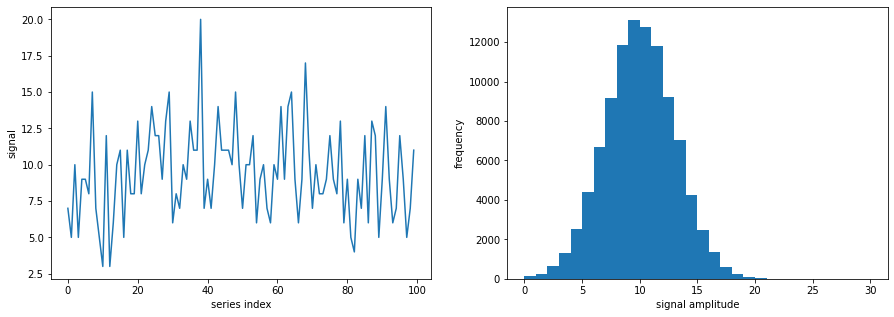

In [34]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
p1 = axes[0].plot(arr[:100])
axes[0].set_xlabel('series index')
axes[0].set_ylabel('signal')
p2 = axes[1].hist(arr, 30, (0, max(30, max(arr) * 1.1)))
axes[1].set_xlabel('signal amplitude')
axes[1].set_ylabel('frequency')

Let's introduce a bunch of basic functionality for handling CDM signals by importing a custom python object class called CDMcode. Each time you construct a new object of this class, you get a complete set of codes for multiplexing messages from different channels into a combined signal at the transmitter, and for demultiplexing messages to different channels from the combined signal at the receiver. The process of multiplexing is called "encoding", and demultiplexing is called "decoding".

In [23]:
import numpy as np

class CDMcode:
    def __init__(self, log2length):
        """
        Constructs a new CDMcode object of length 2**log2length.
        Initialize the first code to a random bit string, and the
        subsequent log2length codes to the complete set of codes
        that are orthogonal to the first.
        """
        self.codelen = 1 << log2length
        arr = np.random.randint(2, size=self.codelen)
        code0 = np.array(arr, dtype=int)
        count = np.arange(self.codelen, dtype=int)
        self.code = [code0]
        self.coda = [2 * code0 - 1]
        self.codi = [-2 * code0 + 1]
        self.coda8 = [np.array(self.coda[0], dtype=np.byte)]
        self.codi8 = [np.array(self.codi[0], dtype=np.byte)]
        for n in range(log2length):
            coden = np.bitwise_xor(code0, (count >> n) & 1)
            self.code.append(coden)
            self.coda.append(2 * coden - 1)
            self.codi.append(-2 * coden + 1)
            self.coda8.append(np.array(self.coda[-1], dtype=np.byte))
            self.codi8.append(np.array(self.codi[-1], dtype=np.byte))
        self.codasum = [np.sum(coda) for coda in self.coda]
    
    def encode(self, message, chan):
        """
        Takes in a message bytestring and expands it into a signal
        array encoded using the code for channel chan, returning it
        as a numpy array of byte containing the bit values of the
        encoded message, length = len(message) * codelen * 8. The
        bit order in the encoded signal is big-endian.
        """
        bitstream = []
        for mbyte in message:
            for mbit in reversed(range(8)):
                if (mbyte >> mbit) % 2 == 0:
                    bitstream.append(self.codi8[chan])
                else:
                    bitstream.append(self.coda8[chan])
        return np.concatenate(bitstream)

    def decode(self, signal, chan, amp=1):
        """
        Takes in a signal array of bytes and decode any messages found
        in code channel chan. Null bits in the signal are treated as
        message termination. Valid message bits are expected to occur
        in sequences of 8 bits, otherwise a warning message is printed.
        The amplitude of the encoded signal is assumed to be amp.
        """
        dotmean = np.sum(signal) * self.codasum[chan] / len(signal)
        pthresh = dotmean + self.codelen * amp / 2
        nthresh = dotmean - self.codelen * amp / 2
        message = bytearray()
        pos = 0
        while pos + 8 * self.codelen <= len(signal):
            mbyte = 0
            for mbit in reversed(range(8)):
                sdotc = self.dot(signal[pos:], chan)
                if sdotc > pthresh:
                    mbyte += (1 << mbit)
                elif sdotc > nthresh:
                    if mbit != 7:
                        print("CDMcode.decode warning:",
                              "incomplete character found at position",
                              pos / self.codelen)
                    return bytes(message)
                pos += self.codelen
            message.append(mbyte)
        return bytes(message)
    
    def dot(self, signal, chan):
        """
        Take the inner product between the array signal[:codelen]
        and the code for channel chan. The signal array is assumed to
        be at least of length codelen.
        """
        return np.dot(self.coda[chan], signal[:self.codelen])

###### Warm-up
For simplicity, the CDMcode class assumes that the cdm codes are a power of 2 in length. This same power of 2 is what limits the total number of separate channels that can be multiplexed on a signal using this CDMcode object. This power is passed as an argument to the constructor. For example, CDMcode(5) would produce a CDMcode object that implements a cdm scheme with 6 (5 + 1) separate channels and a code length of 32. In this simple example, we set up such a scheme with 6 channels, and transmit a simple message over channel 2.

In [27]:
cdm = CDMcode(5)
signal = cdm.encode(b"Hello, world!", 2)
print("signal is a time series with", len(signal), "bytes.")

signal is a time series with 3328 bytes.


Now lets cycle through all 6 channels and see if we can find the one that has the message encoded on it. Play around with the above encoding. Add an offset to the signal, and try adding some random background noise. Is the algorithm still able to detect the correct message on the right channel? At what point does the noise start to interfere with the fidelity of the message?

In [29]:
for chan in range(6):
    msg = cdm.decode(signal, chan)
    if len(msg) > 0:
        print("found a message on channel", chan, msg)

found a message on channel 2 b'Hello, world!'


## The challenge problem
Now it is time to tackle the main challenge of this project. You have been given a signal stored in a plain text file found in your notebook directory. The file has a name like cdm_signal_N.csv where N is some small integer that the instructor uses to identify which signal you have been assigned to study. The CDMcode object that was used to encode secret messages into this signal is also stored in the same project directory under the name cdm_codes_N.dat. Use code like the following to load this CDMcode object into your project workspace. You will need to replace the symbol N in the filename with the specific number you were given.

In [32]:
import pickle
cdm = pickle.load(open("cdm_codes_N.dat", "rb"))
print("loaded CDMcode object with code length", cdm.codelen)

loaded CDMcode object with code length 65536


The rest of this project is for you to work out. The general steps you need to complete are as follows.
<ol>
    <li>Open the input text file and read in the signal values, loading them into a numpy byte array in your notebook.</li>
    <li>Search through the signal for the start of a message. Messages can start at any arbitrary place in the signal, so you need to measure the correlation of the code for each channel with the signal starting at all possible offsets, and look for a non-random correlation that indicates where the message starts.</li>
    <li>Once you have found the beginning of a message on any channel, extract the message until the correlation vanishes. There is at most one message on any given channel, so once you have seen a message terminate, there is no need to continue to search the signal on that channel.</li>
    <li>Divide your notebook up into sections, with text blocks ahead of each code block explaining what the code block is intended to do.</li>
    <li>Your last cell in the notebook should be the one where you tell what messages you have found, what channels they were transmitted on, and what their offsets into the signal were.
        </ol>